## Testing, testing:

This notebooks runs the whole of northern australia script that produced the pizza slice anomalies on a small shapefile that intersects the boundary of an anomaly. 
Then it plots an image of the result.

This is Dask_Wetness_nbart.py as run across the whole of northern australia, but run only on a single small shapefile created to highlight an anomalous region.
Bex 31/07/2017.


In [1]:
#!/usr/bin/env python
#Dask_Wetness_nbarT.py

''' 
Dask_Wetness_nbarT.py loads surface reflectance data from the data cube, calculates 
tasselled cap indices, and outputs a netcdf file. It uses dask to keep memory use low.
--It requires a PBS submission script to provide i, the polygon number to ingest.
Created by Bex Dunn 08/05/2017
Altered to increase the size of the query, to test dask run times, 16/06/17
Altered to use the correct terrain masking nan values 30/06/17
Altered to just use the polygon size again 30/06/17 #FIXME will need to remove the spatial query code (commented out)
'''f
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

#save netcdf outputs to this folder:
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
#code to work with a polygon input rather than a lat/long box
# #pick a shape file
shape_file = ('/home/547/rjd547/QGIS_stuff/slice.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)

#i is the number of the polygon within the shapefile that the script will run for.
#the next line takes i  as a system argument input eg. $Dask_Wetness_nbarT.py $1
#We have to minus one here because python counts from 0 and bash counts from one, therefore
#node 1 will be polygon 0.

#i=int(sys.argv[1])-1 
i=0
print('i is :'+str(i))
#if we have requested an i greater than the amount of polygons in the file, just print an error message
#exit with success condition (0) not failure condition (anything else)
if i > len(shapes):
    print('index not in the range for the shapefile: '+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)

#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

#geom.boundingbox
#using a spatial query while testing the size of the bounding box we can use while running dask #FIXME
#spatial_q = {
#    'x': (geom.boundingbox.left-47500, geom.boundingbox.right+47500), 
#    'y': (geom.boundingbox.top+47500, geom.boundingbox.bottom-47500),
#    'crs': geom.crs.wkt,
#    }
#print((spatial_q['x'][1]-spatial_q['x'][0])/1000,'km Easting')
#print((spatial_q['y'][0]-spatial_q['y'][1])/1000,'km Northing')
#spatial_q

#bring in dask and start it running
import dask
dask.set_options(get=dask.get)

#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbar')

#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls5'
sensor2 = 'ls7'
sensor3 = 'ls8'

query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
    'dask_chunks': {'time': 5},
}
#query.update(spatial_q)

#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

wetness_coeff = {}
wetness_coeff['ls5'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls7'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
#wetness_coeff['ls7'] = (0.2626, 0.2141, 0.0926, 0.0656, -0.7629, -0.5388)
wetness_coeff['ls8'] = (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559)


## PQ and Index preparation
# retrieve the NBAR and PQ for the spatiotemporal range of interest
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
           
crs = sensor1_nbar.crs
crswkt = sensor1_nbar.crs.wkt
affine = sensor1_nbar.affine

#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)
sensor1_nbar.attrs['crs'] = crs
sensor1_nbar.attrs['affine'] = affine

sensor2_nbar = dc.load(product= sensor2+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)
sensor2_nbar.attrs['crs'] = crs
sensor2_nbar.attrs['affine'] = affine

sensor3_nbar = dc.load(product= sensor3+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)
sensor3_nbar.attrs['crs'] = crs
sensor3_nbar.attrs['affine'] = affine

#__________This section included so nbarT is correctly used to correct terrain by removing -999.0 values and replacing with nans________________________
sensor1_nbar = sensor1_nbar.where(sensor1_nbar!=-999.0)
sensor2_nbar = sensor2_nbar.where(sensor2_nbar!=-999.0)
sensor3_nbar = sensor3_nbar.where(sensor3_nbar!=-999.0)

#Calculate Taselled Cap Wetness
wetness_sensor1_nbar = ((sensor1_nbar.blue*wetness_coeff[sensor1][0])+
                        (sensor1_nbar.green*wetness_coeff[sensor1][1])+
                        (sensor1_nbar.red*wetness_coeff[sensor1][2])+
                        (sensor1_nbar.nir*wetness_coeff[sensor1][3])+
                        (sensor1_nbar.swir1*wetness_coeff[sensor1][4])+
                        (sensor1_nbar.swir2*wetness_coeff[sensor1][5])
                       )
wetness_sensor2_nbar = ((sensor2_nbar.blue*wetness_coeff[sensor2][0])+(sensor2_nbar.green*wetness_coeff[sensor2][1])+
                          (sensor2_nbar.red*wetness_coeff[sensor2][2])+(sensor2_nbar.nir*wetness_coeff[sensor2][3])+
                          (sensor2_nbar.swir1*wetness_coeff[sensor2][4])+(sensor2_nbar.swir2*wetness_coeff[sensor2][5]))
wetness_sensor3_nbar = ((sensor3_nbar.blue*wetness_coeff[sensor3][0])+(sensor3_nbar.green*wetness_coeff[sensor3][1])+
                          (sensor3_nbar.red*wetness_coeff[sensor3][2])+(sensor3_nbar.nir*wetness_coeff[sensor3][3])+
                          (sensor3_nbar.swir1*wetness_coeff[sensor3][4])+(sensor3_nbar.swir2*wetness_coeff[sensor3][5]))

threshold = -400

#for wetness_sensor1_nbar, filter, count, and load.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    water_plus_wetveg_1 = wetness_sensor1_nbar.where(wetness_sensor1_nbar>threshold)

#count the number of wetness scenes for each pixel
wet_count_1 = wetness_sensor1_nbar.count(dim='time')

#count the amount of times that water plus wet veg is above the threshold
threshold_count_1= water_plus_wetveg_1.count(dim='time')

#bring both counts into memory 
wet_count_1.load()
threshold_count_1.load() 

#for wetness_sensor2_nbar, filter, count, and load.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    water_plus_wetveg_2 = wetness_sensor2_nbar.where(wetness_sensor2_nbar>threshold)
#print(water_plus_wetveg_2)

#count the number of wetness scenes for each pixel
wet_count_2 = wetness_sensor2_nbar.count(dim='time')

#count the amount of times that water plus wet veg is above the threshold
threshold_count_2= water_plus_wetveg_2.count(dim='time')

#bring both counts into memory
wet_count_2.load()
threshold_count_2.load() 

#for wetness_sensor3_nbar, filter, count, and load.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    water_plus_wetveg_3 = wetness_sensor3_nbar.where(wetness_sensor3_nbar>threshold)

#count the number of wetness scenes for each pixel
wet_count_3 = wetness_sensor3_nbar.count(dim='time')

#count the amount of times that water plus wet veg is above the threshold
threshold_count_3= water_plus_wetveg_3.count(dim='time')

#bring both counts into memory
wet_count_3.load()
threshold_count_3.load() 

# #divide the number of times wetness is seen by the number of wetness scenes to get a proportion of time that the 
# #pixel is wet or wet veg'd:
threshold_allsensors = threshold_count_1+threshold_count_2+threshold_count_3
wet_count_allsensors = wet_count_1+ wet_count_2+ wet_count_3

# #divide the number of times wetness is seen by the number of wetness scenes to get a proportion of time that the 
# #pixel is wet or wet veg'd:
wet_proportion_allsensors= threshold_allsensors/wet_count_allsensors

#turn array into dataset so we can write the netcdf
dataset_tcw = wet_proportion_allsensors.to_dataset(name='tcw')

#grab our crs attributes to write a spatially-referenced netcdf
dataset_tcw.attrs['crs'] =  sensor1_nbar.crs
dataset_tcw.tcw.attrs['crs'] =  sensor1_nbar.crs

i is :0


/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)
/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)
/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


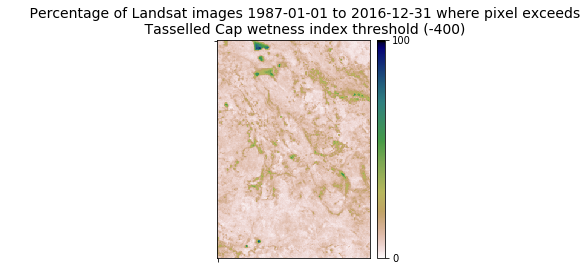

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#clear figure to preserve memory
plt.clf()

from mpl_toolkits.axes_grid1 import make_axes_locatable
#specify figure size
plt.figure(figsize=(4,4))
gs = gridspec.GridSpec(1, 1)#, width_ratios=(12, 1))
#plot the image on the axes
ax1 = plt.subplot(gs[0,0])
img = ax1.imshow(wet_proportion_allsensors, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

#get rid of the axes labels and ticks
ax1.axes.set_xlabel('')
ax1.axes.set_xticklabels([''])
ax1.axes.set_xticks([0])
ax1.axes.set_ylabel('')
ax1.axes.set_yticklabels([''])
ax1.axes.set_yticks([0])

#set title
for_title = str('     Percentage of Landsat images {0} to {1} where pixel exceeds\n\
     Tasselled Cap wetness index threshold (-400)'.format(start_of_epoch,end_of_epoch))
plt.title(for_title, 
          multialignment ='center',fontsize =14)#,
        # y=1.05, x =0.83)

#find the edge of the plot so that we can set the colourbar next to it
divider = make_axes_locatable(ax1)  
cax1 = divider.append_axes("right", size='5%', pad=0.1)
    
#set colourbar to same length as plot and set range to [0,100]    
cbar = plt.colorbar(img,cax=cax1, ticks =[0,1])
cbar.ax.set_yticklabels(['0','100'])


#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/.png',
#box_inches='tight', pad_inches=0, transparent=True)

plt.show()


In [4]:
filename = netcdf_output_loc+shape_name+'.nc'
try:
    write_dataset_to_netcdf(dataset_tcw, filename)
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
    
print('successfully ran TCI for '+shape_name+' polygon number '+str(i))
eprint('successfully ran TCI for '+shape_name+' polygon number '+str(i))

successfully ran TCI for slice_0 polygon number 0


successfully ran TCI for slice_0 polygon number 0
